(0, 1)

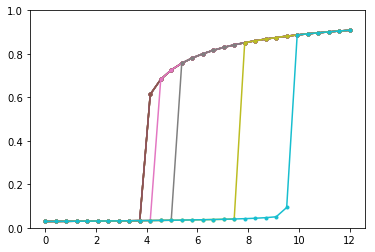

In [1]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import math
import matplotlib.pylab as plt
%matplotlib inline

duration = 50

L=1
N=100


def singlerun(mu,lamb,solver,f):
    k2=1
    k3=mu*k2/N/N
    k1=k2*lamb

    with reaction_rules():
        X == Y | (k1,k2)
        X + 2*Y > 3*Y |k3
    m = get_model()
    obs=run_simulation(duration,model=m,y0={'X':N*f,'Y':N*(1-f)},return_type='observer',species_list=['Y'],solver=solver,volume=ones()*L)
    data = np.array(obs.data()).T   
    out=data[1][-1]
    return out

mus=np.linspace(0,12,30)

la=0.03
solver='ode'
for f in np.linspace(0,1,10):
    ys=[]
    for mu in mus:
        ny=singlerun(mu,la,solver,f)
        nx=N-ny
        ys.append(ny/N)
    plt.plot(mus,ys,'.-',label='f'+str(f))

#plt.plot(mus,[la+(m-1)*la**2 for m in mus],'--')
#plt.plot(mus,[1-1./m-(1-la)/m/m for m in mus],'--')
mm = np.linspace(4,12,30)
#plt.plot(mm,[0.5+math.sqrt(m*m-4*m)/(2*m) for m in mm],'--')
#plt.plot(mm,[0.5-math.sqrt(m*m-4*m)/(2*m) for m in mm],'--')
plt.ylim(0,1)
#viz.plot_number_observer(obs) #divide by actual volume to get concentration

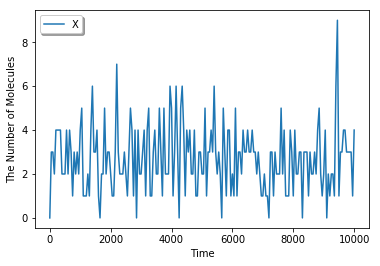

In [1]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import math
import matplotlib.pylab as plt
%matplotlib inline
duration = 10000

L=5
N=20
D=1
D2=D*0.1
V=L**3
dt=50

def singlerun(r1,r2,r3):
    solver='gillespie'
    k2=1
    k4=1
    k6=1
    k1=k2*r1
    k3=k4*r2
    k5=k6*r3
    with species_attributes():
        A | {'D': D}
        B | {'D': D}    
        X2 | {'D': D2}    
        X | {'D': D}    
    with reaction_rules():
        A == X | (k1,k2)
        X+X==X2 | (k3,k4)
        X2+B == X+X2 | (k5,k6)
    m = get_model()
    w = gillespie.GillespieWorld(Real3(L,L,L))
    w.bind_to(m)
    w.add_molecules(Species('A'),N)
    sim = gillespie.GillespieSimulator(w)    
    obs = FixedIntervalNumberObserver(dt, ['X'])
    sim.run(duration,obs)
    data = np.array(obs.data()).T
    #out=np.mean(data[-20:])
    return obs#out

ys=[]

#for mu in mus:
#    ny=singlerun(mu,la,solver)
#    ys.append(ny/N)
#print(ys)
#plt.plot(mus,ys,'-')
#plt.plot(mus,[la+(m-1)*la**2 for m in mus],'--')
#plt.plot(mus,[1-1./m-(1-la)/m/m for m in mus],'--')
#mm = np.linspace(4,12,30)
#plt.plot(mm,[0.5+math.sqrt(m*m-4*m)/(2*m) for m in mm],'--')
#plt.plot(mm,[0.5-math.sqrt(m*m-4*m)/(2*m) for m in mm],'--')
obs=singlerun(0.2,1,1)
viz.plot_number_observer(obs) #divide by actual volume to get concentration

In [47]:
0.5/3

0.16666666666666666

In [ ]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

duration = 1000

L=1
def singlerun():
    V = L**3 
    Nb=int(Cb*V)
    M = max(int(min(cbrt(Nb), L / (2 * rm))), 3)        
    rv=rm
    if solver=='spa':
        rv=rm*1.0208582
        solver=("spatiocyte",rv)
        V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),rm*1.0208582)    
    elif solver=='G':
        solver = ("gillespie")
    elif solver=='egfrd':
        solver=('egfrd', Integer3(M, M, M))    
    keff = k0/Ca/Cb   #degradation rate
    kd = 4*np.pi*rm*2*D*2
    ka = keff*kd/(kd-keff)  #bimolecular intrinsic rate
    assert(ka>0)
    #reaction model:
    with species_attributes():
        A | {'D': D, 'radius':rv  }
        B | {'D': D, 'radius':rv  }

    with reaction_rules():
        ~A > A | k0
        A + B >B | (ka if intrinsic else keff)
    m = get_model()
    obs=run_simulation(duration,model=m,y0={'B':Nb},return_type='observer',species_list=['A'],solver=solver,volume=ones()*L)
    data = np.array(obs.data()).T
    #print('mean [A]',np.mean(data[1][50:])/V)   
    return obs

obs=singlerun(0.005,0.1,'ode',False)
viz.plot_number_observer(obs) #divide by actual volume to get concentration

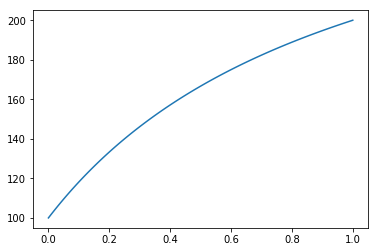

In [11]:
m1=100
m2=300
t=np.linspace(0,1,100)
y=(m1+t*m2)/(1+t)
plt.plot(t,y)

nosimrun 500


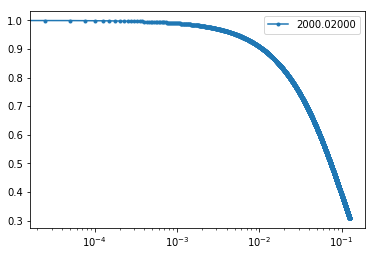

In [2]:
import glob
import os.path

def calk(stsim,t,C): #get kt from st
    dst = (stsim[2:]-stsim[:-2])/(t[2:]-t[:-2])
    dst=np.append((stsim[1]-stsim[0])/(t[1]-t[0]),dst)
    dst=np.append(dst,(stsim[-1]-stsim[-2])/(t[-1]-t[-2])  )
    return -dst/stsim/C

ds=1

patterns = ['/home/chew/outputdata/keff/2D/kfac0.01_N2000_L5/*',
            '/home/chew/outputdata/keff/2D/kfac0.01_N2500_L5/*',
            '/home/chew/outputdata/keff/2D/kfac0.01_N12500_L5/*',
            '/home/chew/outputdata/keff/2D/kfac0.01_N25000_L5/*'
           ]

def getkt(N,C,pattern):   
    fns = glob.glob(pattern)
    y=0
    for fn in fns[:500]:
        r=np.loadtxt(fn,delimiter=',')
        y+=np.array(r).T[1][::ds]
    x=np.array(r).T[0][::ds]
    print('nosimrun',len(fns))
    y/=len(fns)
    s=y/N
    kt = calk(s,x,C)
    #plt.loglog(x,kt,'.',label=str(C)+str(N))
    plt.semilogx(x,s,'.-',label=str(C)+str(N))
    return x,kt        

t1,kt1=getkt(2000,2000/L/L,patterns[0])
#t1,kt1=getkt(2500,2500/L/L,patterns[1])
#t1,kt1=getkt(12500,12500/L/L,patterns[2])
#t1,kt1=getkt(25000,25000/L/L,patterns[2])
#t1b,kt1b=getkt(res[0],N,N/L/L)
#t2,kt2=getkt(res[1],1188,conc)
plt.legend()